In [1]:
pip install "qc-grader[qiskit,jupyter] @ git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git"

  Cloning https://github.com/qiskit-community/Quantum-Challenge-Grader.git to /tmp/pip-install-0d3l9t9e/qc-grader_096ab3188b7e486288341b925ffb3b09
  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/Quantum-Challenge-Grader.git /tmp/pip-install-0d3l9t9e/qc-grader_096ab3188b7e486288341b925ffb3b09
  Resolved https://github.com/qiskit-community/Quantum-Challenge-Grader.git to commit 1d7a6915623b0cfeac4c114391c279e9d98eb7f9
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
import qiskit
import qc_grader
print(f"Qiskit version: {qiskit.__version__}")
print(f"Grader version: {qc_grader.__version__}")

Qiskit version: 2.1.1
Grader version: 0.22.12


In [3]:
# Check that the account has been saved properly
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(name="qgss-2025")
service.saved_accounts()

{'qgss-2025': {'channel': 'ibm_quantum_platform',
  'url': 'https://cloud.ibm.com',
  'token': 'xi0nZf18SfBZn-P1f124QEWDywbHVDPldD9sjHLkYjNE',
  'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/28121048c51949f9a93006ccbc7b3faf:edce2be1-5f4f-4532-9d3d-72a7b8c6538d::',
  'verify': True,
  'private_endpoint': False}}

In [4]:
# Import common packages first
import numpy as np

# Import qiskit classes
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram

# Import utils and cosystems
from lab4_util import hamming_distance, minimum_distance, bring_states, matrixRank
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2  as Sampler

# Import grader
from qc_grader.challenges.qgss_2025 import (
    grade_lab4_ex1, 
    grade_lab4_ex2, 
    grade_lab4_ex3,
    grade_lab4_ex4,
    grade_lab4_ex5,
    grade_lab4_ex6
)

In [5]:
# Example usage:
str1 = "10110"
str2 = "11100"
dist = hamming_distance(str1, str2)
print(f"Hamming distance between '{str1}' and '{str2}' is: {dist}") # Output: 2

vec1 = [1, 0, 0, 1]
vec2 = [0, 0, 1, 1]
dist_vec = hamming_distance(vec1, vec2)
print(f"Hamming distance between {vec1} and {vec2} is: {dist_vec}") # Output: 2

Hamming distance between '10110' and '11100' is: 2
Hamming distance between [1, 0, 0, 1] and [0, 0, 1, 1] is: 2


In [6]:
# --- Example: A Simple [4, 3, 2] Parity Check Code ---
# This code takes 3 message bits (k=3) and adds an even parity bit
# to make the total codeword length n=4.
# Messages: 000, 001, 010, 011, 100, 101, 110, 111
# Codewords (adding even parity bit):
parity_code_4_3 = [
    "0000", # 000 + 0 (even parity)
    "0011", # 001 + 1
    "0101", # 010 + 1
    "0110", # 011 + 0
    "1001", # 100 + 1
    "1010", # 101 + 0
    "1100", # 110 + 0
    "1111"  # 111 + 1
]

# Calculate the minimum distance d
d_parity = minimum_distance(parity_code_4_3)
print(f"Codewords: {parity_code_4_3}")
print(f"Calculated minimum distance d = {d_parity}") # Output: 2

Codewords: ['0000', '0011', '0101', '0110', '1001', '1010', '1100', '1111']
Calculated minimum distance d = 2


In [7]:
# --- Example: [3, 1, 3] Repetition Code ---
repetition_code_3_1 = ["000", "111"]
d_repetition = minimum_distance(repetition_code_3_1)
print(f"Calculated minimum distance d = {d_repetition}") # Output: 3

# Capabilities for d=3:
t_detect = d_repetition - 1
t_correct = int((d_repetition - 1) / 2) // 1
print(f"Error Detection Capability (t_detect = d-1): {t_detect}") # Output: 2
print(f"Error Correction Capability (t_correct = floor((d-1)/2)): {t_correct}") # Output: 1

Calculated minimum distance d = 3
Error Detection Capability (t_detect = d-1): 2
Error Correction Capability (t_correct = floor((d-1)/2)): 1


In [8]:
test_str = "010"

print("Hamming distance between 010 and 000 is", hamming_distance(test_str, "000"))
print("Hamming distance between 010 and 111 is", hamming_distance(test_str, "111"))

Hamming distance between 010 and 000 is 1
Hamming distance between 010 and 111 is 2


In [9]:
hardcode_decoder_3_1_3 = {
    '000': '0',  # No error
    '001': '0',  # Single-bit error corrected to 000
    '010': '0',  # Single-bit error corrected to 000
    '011': '1',  # Single-bit error corrected to 111
    '100': '0',  # Single-bit error corrected to 000
    '101': '1',  # Single-bit error corrected to 111
    '110': '1',  # Single-bit error corrected to 111
    '111': '1'   # No error
}


In [10]:
test_str = "010"
print("Hamming distance between 010 and 000 is", hamming_distance(test_str, "000"))
print("Hamming distance between 010 and 111 is", hamming_distance(test_str, "111"))
print("Decoded bit:", hardcode_decoder_3_1_3[test_str])


Hamming distance between 010 and 000 is 1
Hamming distance between 010 and 111 is 2
Decoded bit: 0


In [11]:
hardcode_decoder_bit_flip_syndrome_map = {
    '00': 'I',    # No error
    '01': 'X2',   # Error on qubit 2
    '10': 'X0',   # Error on qubit 0
    '11': 'X1'    # Error on qubit 1
}


In [12]:
# Submit your answer using following code
grade_lab4_ex1(hardcode_decoder_bit_flip_syndrome_map )

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [13]:
steane_decoder_syndrome_map = {
    # X errors
    '111000': 'X0',
    '011000': 'X1',
    '101000': 'X2',
    '001000': 'X3',
    '110000': 'X4',
    '010000': 'X5',
    '100000': 'X6',

    # Y errors
    '111111': 'Y0',
    '011011': 'Y1',
    '101101': 'Y2',
    '001001': 'Y3',
    '110110': 'Y4',
    '010010': 'Y5',
    '100100': 'Y6',

    # Z errors
    '000111': 'Z0',
    '000011': 'Z1',
    '000101': 'Z2',
    '000001': 'Z3',
    '000110': 'Z4',
    '000010': 'Z5',
    '000100': 'Z6',

    # No error
    '000000': 'I'
}


In [14]:
# Submit your answer using following code
grade_lab4_ex2(steane_decoder_syndrome_map)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [15]:
def measure_steane_syndrome(qc, q_data, q_anc, c_reg):
    # ---- X-type Stabilizers ----
    qc.h(q_data)  # Convert X basis to Z basis for measurement

    # S0: IIIXXXX (qubits 0,1,2,3)
    qc.cx(q_data[0], q_anc[0])
    qc.cx(q_data[1], q_anc[0])
    qc.cx(q_data[2], q_anc[0])
    qc.cx(q_data[3], q_anc[0])

    # S1: IXXIIXX (qubits 1,2,5,6)
    qc.cx(q_data[1], q_anc[1])
    qc.cx(q_data[2], q_anc[1])
    qc.cx(q_data[5], q_anc[1])
    qc.cx(q_data[6], q_anc[1])

    # S2: XIXIXIX (qubits 0,2,4,6)
    qc.cx(q_data[0], q_anc[2])
    qc.cx(q_data[2], q_anc[2])
    qc.cx(q_data[4], q_anc[2])
    qc.cx(q_data[6], q_anc[2])

    qc.h(q_data)  # Return qubits back to original basis
    qc.measure(q_anc[0:3], c_reg[0:3])
    qc.barrier()

    # ---- Z-type Stabilizers ----
    # S3: IIIZZZZ (qubits 0,1,2,3)
    qc.cx(q_data[0], q_anc[3])
    qc.cx(q_data[1], q_anc[3])
    qc.cx(q_data[2], q_anc[3])
    qc.cx(q_data[3], q_anc[3])

    # S4: IZZIIZZ (qubits 1,2,5,6)
    qc.cx(q_data[1], q_anc[4])
    qc.cx(q_data[2], q_anc[4])
    qc.cx(q_data[5], q_anc[4])
    qc.cx(q_data[6], q_anc[4])

    # S5: ZIZIZIZ (qubits 0,2,4,6)
    qc.cx(q_data[0], q_anc[5])
    qc.cx(q_data[2], q_anc[5])
    qc.cx(q_data[4], q_anc[5])
    qc.cx(q_data[6], q_anc[5])

    qc.measure(q_anc[3:6], c_reg[3:6])
    qc.barrier()


In [16]:
state = bring_states()

# Logical qubit (7 data qubits)
qr_data = QuantumRegister(7, name='q')
# Ancilla qubits for syndrome measurement (6)
qr_anc = QuantumRegister(6, name='anc')
# Classical registers for syndrome (initial & verify)
cr_initial_syn = ClassicalRegister(6, name='c_initial_syn')
cr_final_syn = ClassicalRegister(6, name='c_final_syn')

# Total circuit (13 qubits, 12 classical bits)
qc = QuantumCircuit(qr_data, qr_anc, cr_initial_syn, cr_final_syn)

# ---- TODO : Task 3 ---
# initialize qc with the correct state
qc.initialize(state, qr_data)
# --- End of TODO ---


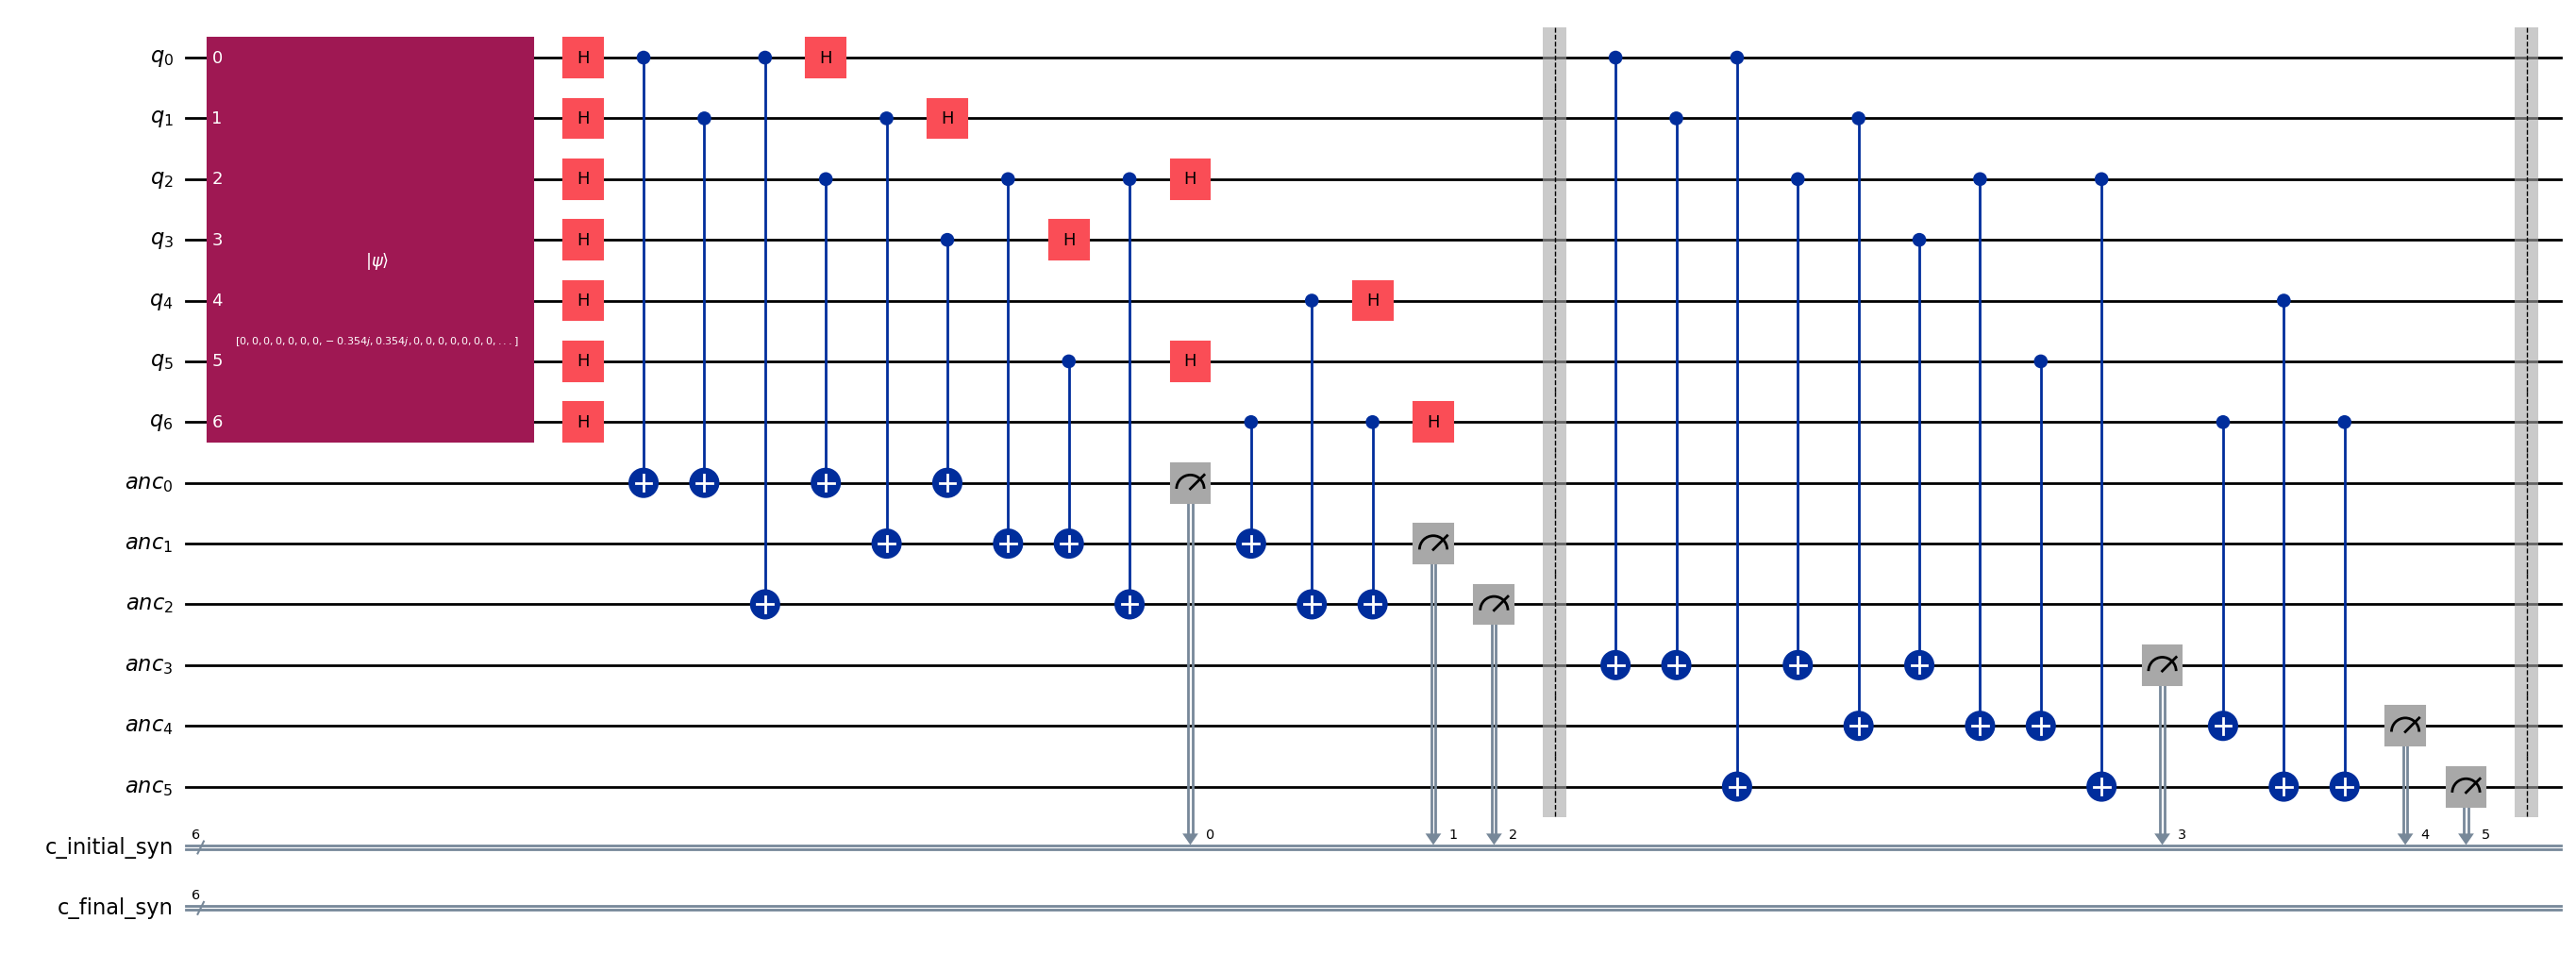

In [17]:
# --- Add Syndrome Measurement ---
measure_steane_syndrome(qc, qr_data, qr_anc, cr_initial_syn)

qc.draw('mpl', fold=-1)


In [18]:
# --- Run the Simulation using AerSimulator
backend = AerSimulator()

# make quantum circuit compatible to the backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
qc_isa = pm.run(qc)

# run and get counts
sampler = Sampler(mode=backend)
counts = sampler.run([qc_isa], shots=10000).result()[0].data.c_initial_syn.get_counts()

# ---- TODO : Task 3 ---
# get key of simulation result and find the error code, ex: X1

key = list(counts.keys())[0]  # Extract the 6-bit syndrome
error_code = steane_decoder_syndrome_map[key]  # Lookup the error code

# --- End of TODO ---


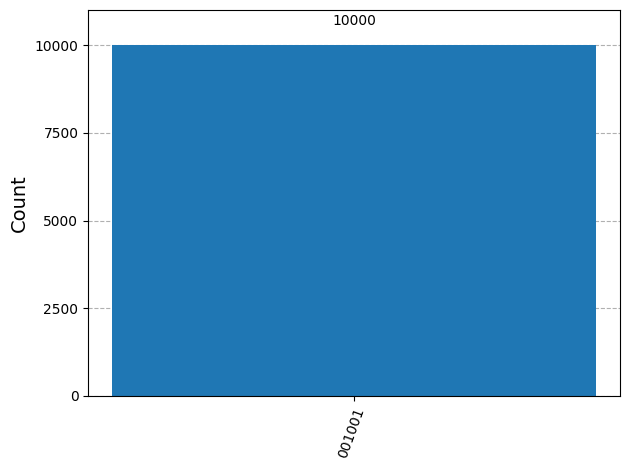

In [19]:
plot_histogram(counts)

In [20]:
# Submit your answer using following code
grade_lab4_ex3(error_code)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


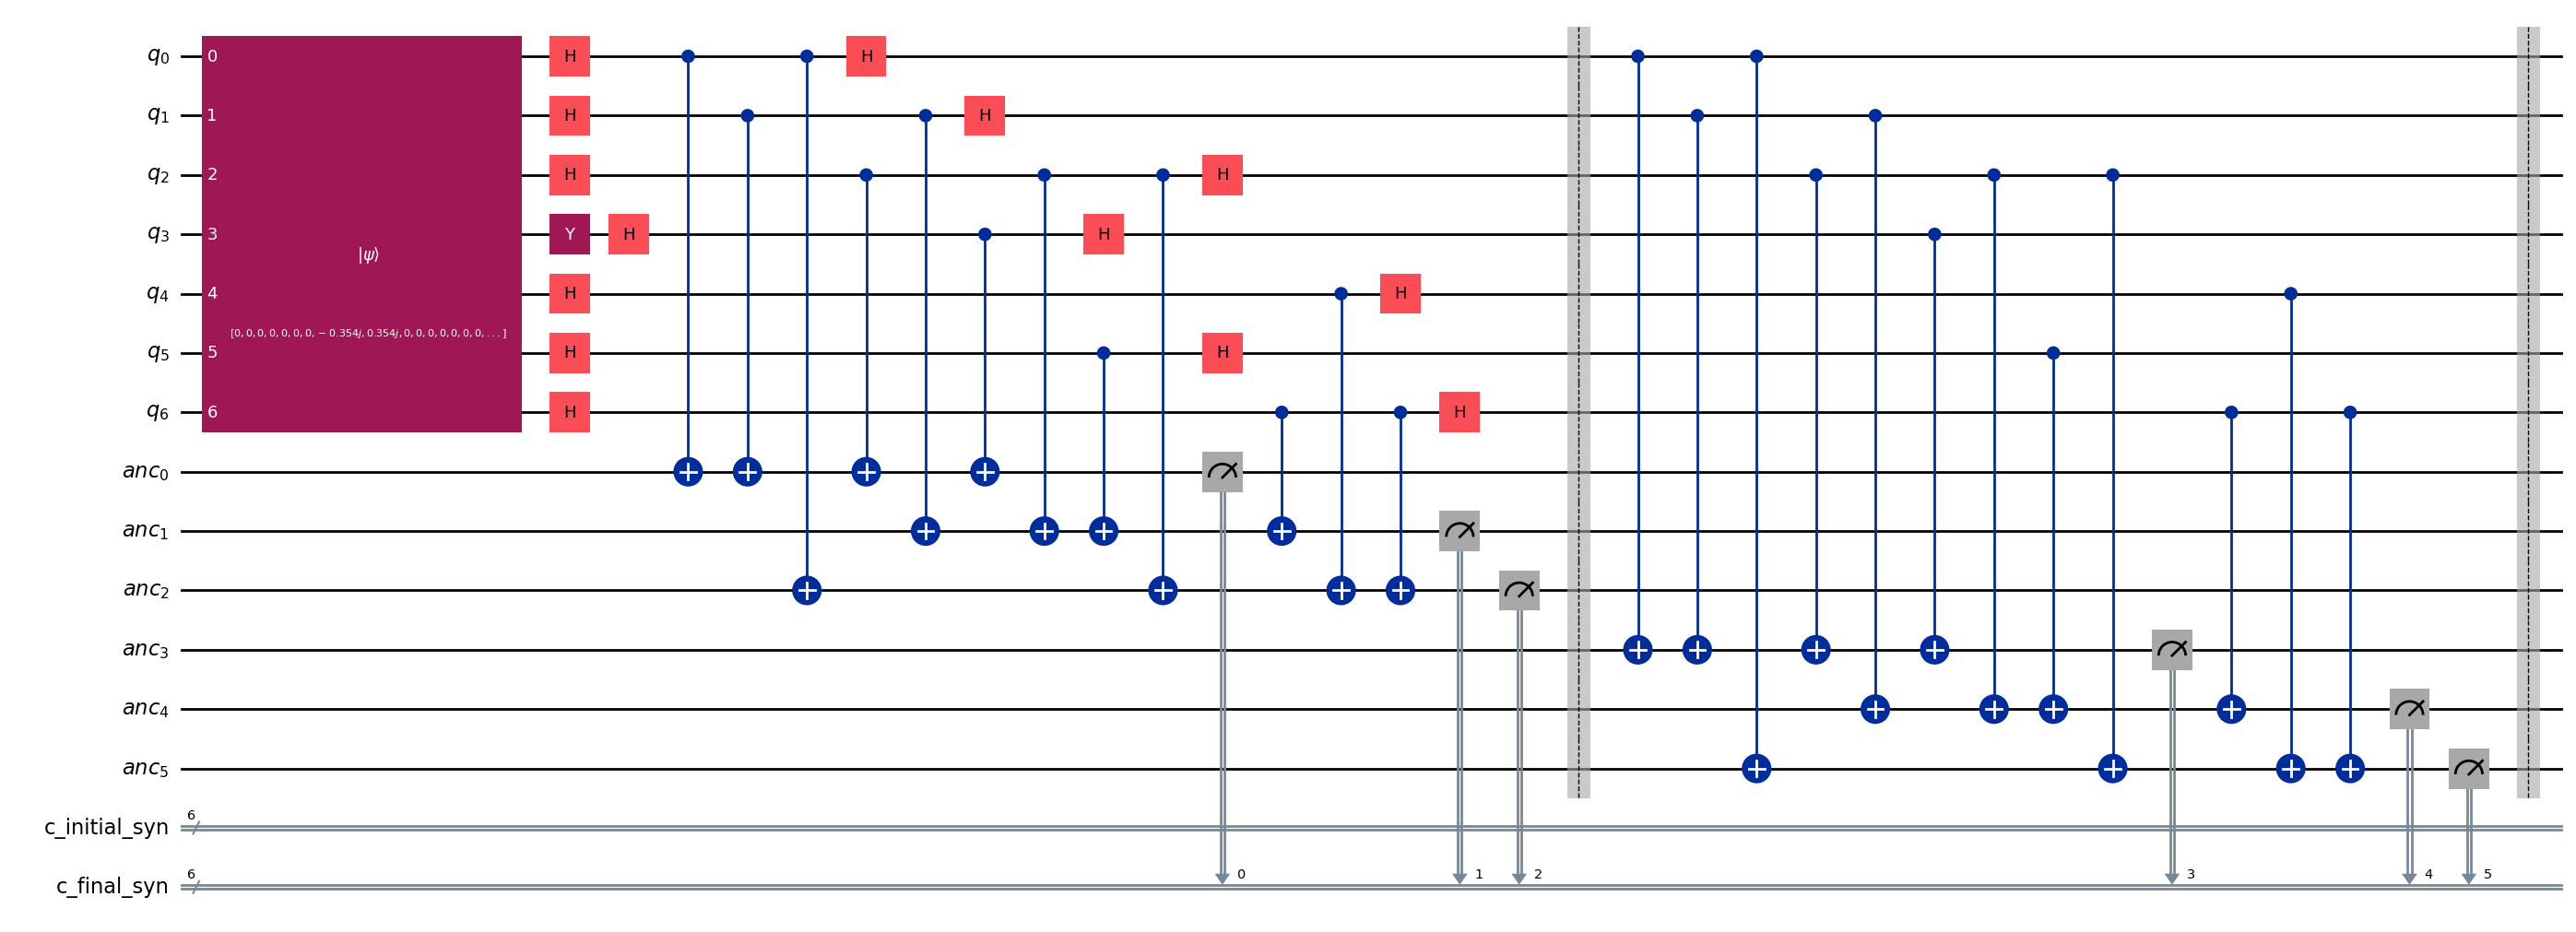

In [21]:
qc = QuantumCircuit(qr_data, qr_anc, cr_initial_syn, cr_final_syn)

# ---- TODO : ungraded task ---
# initialize qr_data with State
qc.initialize(state, qr_data)

# correct error by applying proper gate based on detected error_code
if error_code[0] == 'X':
    qc.x(qr_data[int(error_code[1])])
elif error_code[0] == 'Y':
    qc.y(qr_data[int(error_code[1])])
elif error_code[0] == 'Z':
    qc.z(qr_data[int(error_code[1])])
# If error_code == 'I', do nothing
# --- End of TODO ---

measure_steane_syndrome(qc, qr_data, qr_anc, cr_final_syn)

qc.draw('mpl', fold=-1)


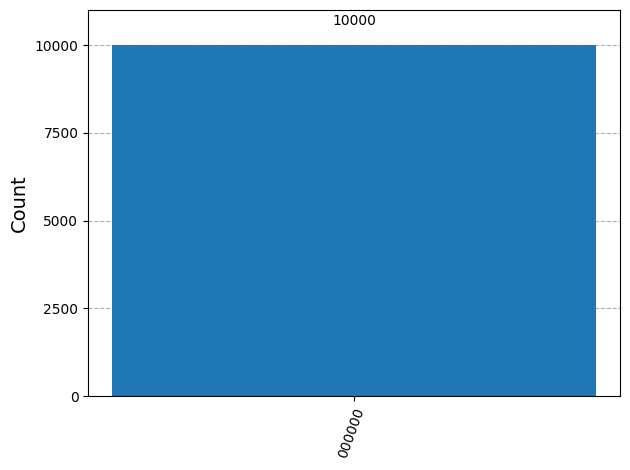

In [22]:
qc_isa = pm.run(qc)
counts = sampler.run([qc_isa], shots = 10000).result()[0].data.c_final_syn.get_counts()

plot_histogram(counts)

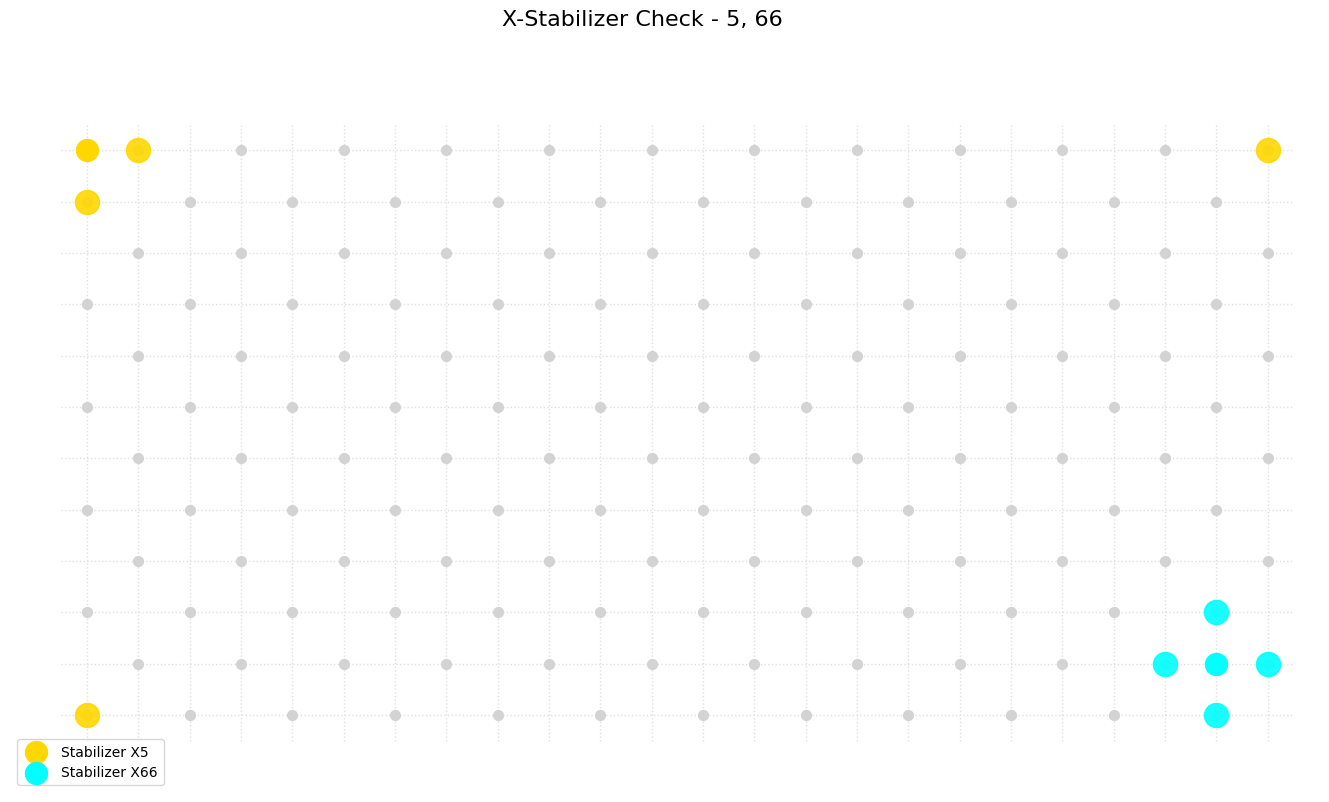

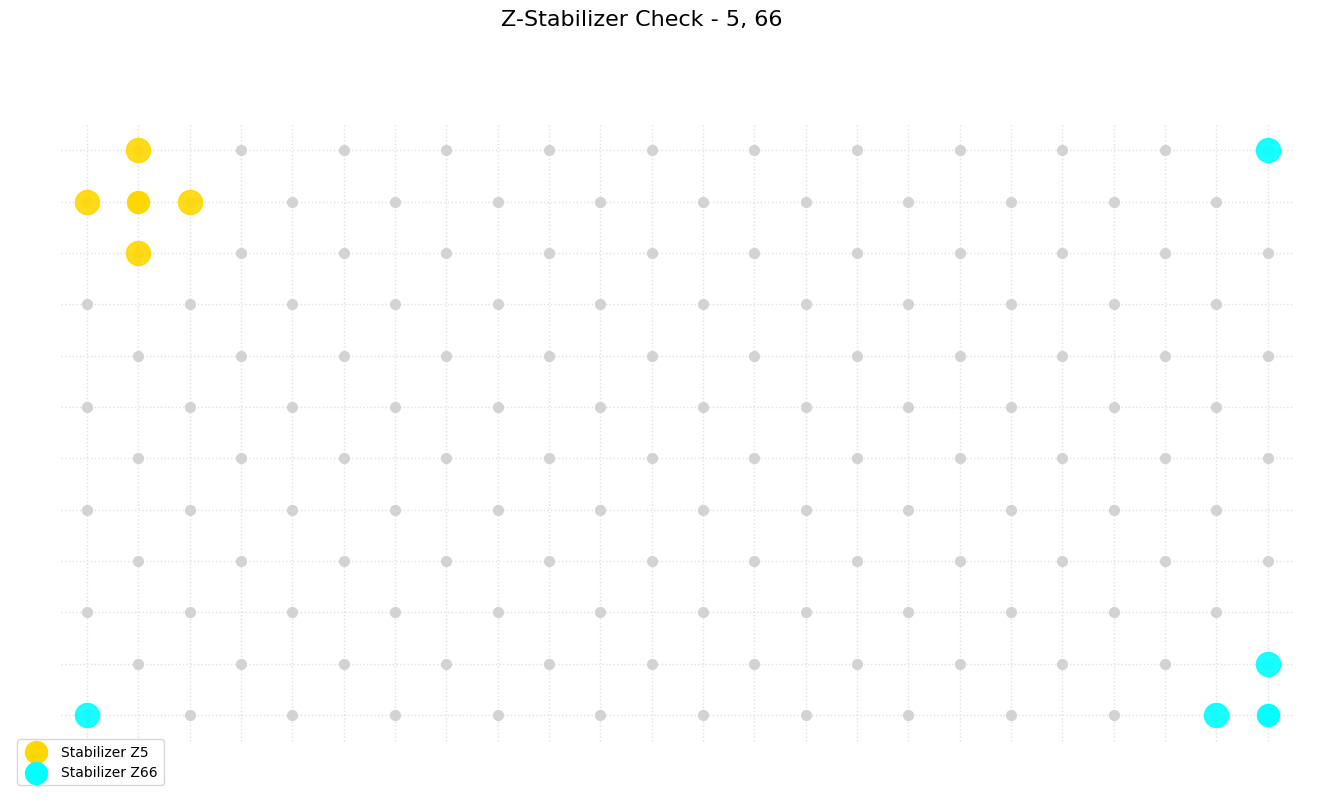

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [23]:
# Initialize parity check matrices
HXtc = np.zeros((72, 144), dtype=int)
HZtc = np.zeros((72, 144), dtype=int)

# Build HXtc using the toric code rules
for j in range(72):
    HXtc[j][j] = 1
    HXtc[j][int(6*np.floor(j/6) + np.mod(j+1, 6))] = 1
    HXtc[j][72 + j] = 1
    HXtc[j][int(72 + 6 * np.mod(np.floor(j/6) - 1, 12) + np.mod(j, 6))] = 1

# Build HZtc using the corrected rules
for j in range(72):
    HZtc[j][j] = 1
    HZtc[j][int(6 * np.mod(np.floor(j/6) + 1, 12) + np.mod(j, 6))] = 1
    HZtc[j][72 + j] = 1
    HZtc[j][int(72 + 6 * np.floor(j/6) + np.mod(j - 1, 6))] = 1

# Plot and grade
from lab4_util import generate_stabilizer_plots
generate_stabilizer_plots(HXtc, HZtc)

grade_lab4_ex4(HXtc, HZtc)


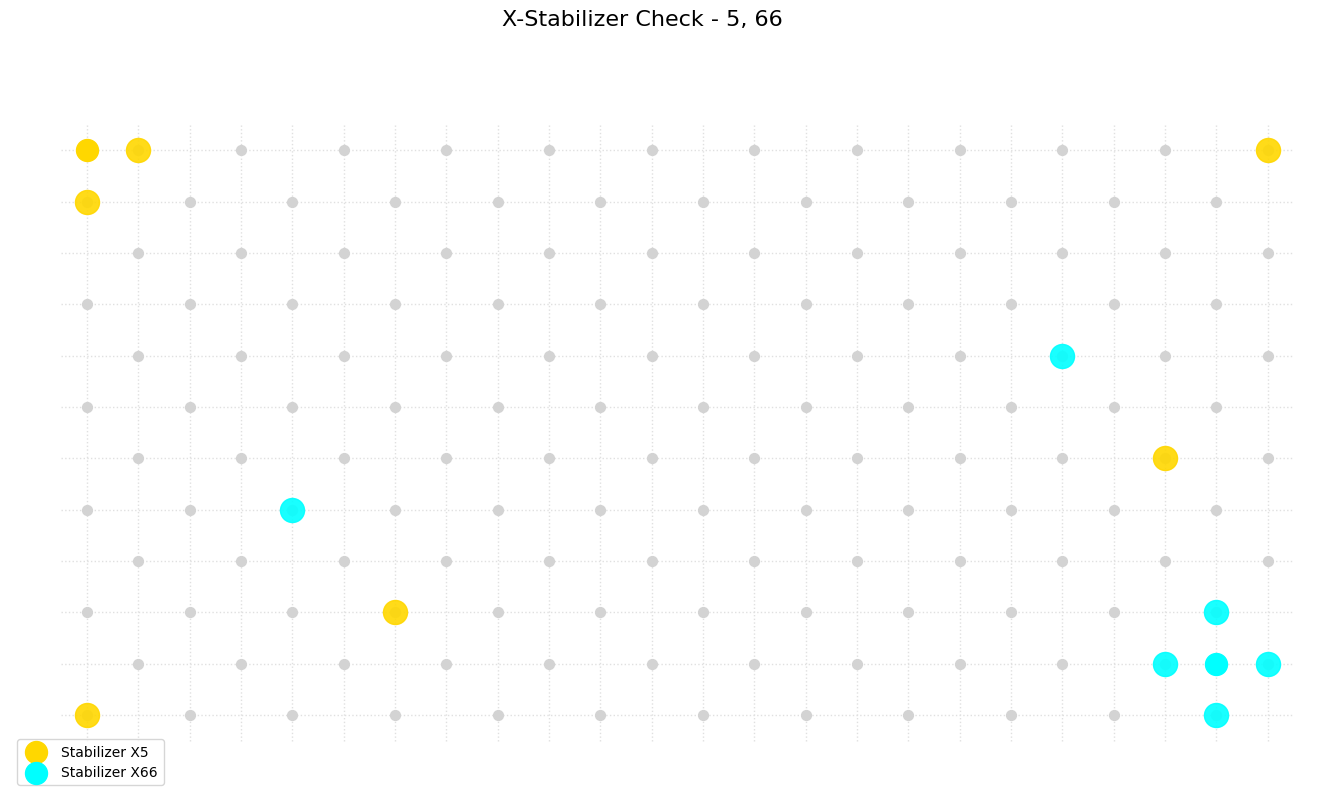

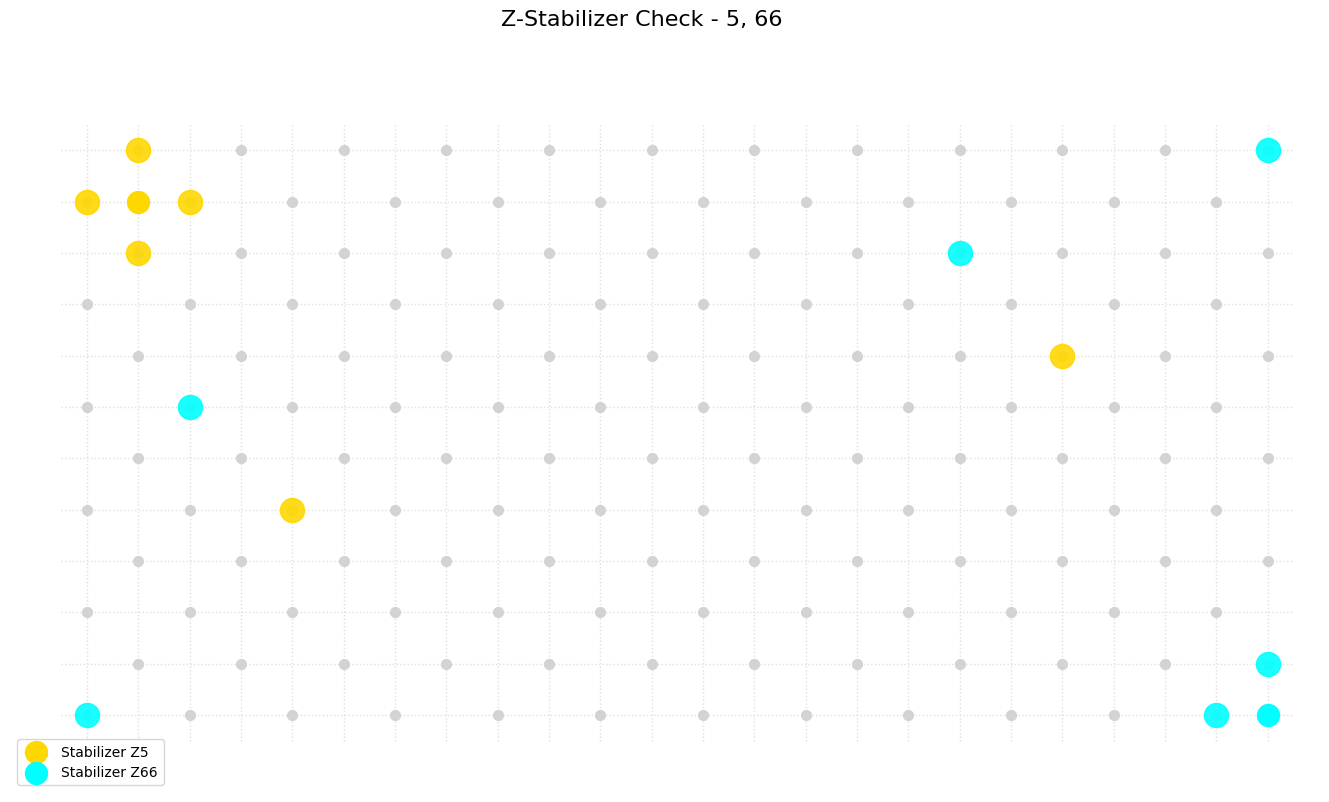

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


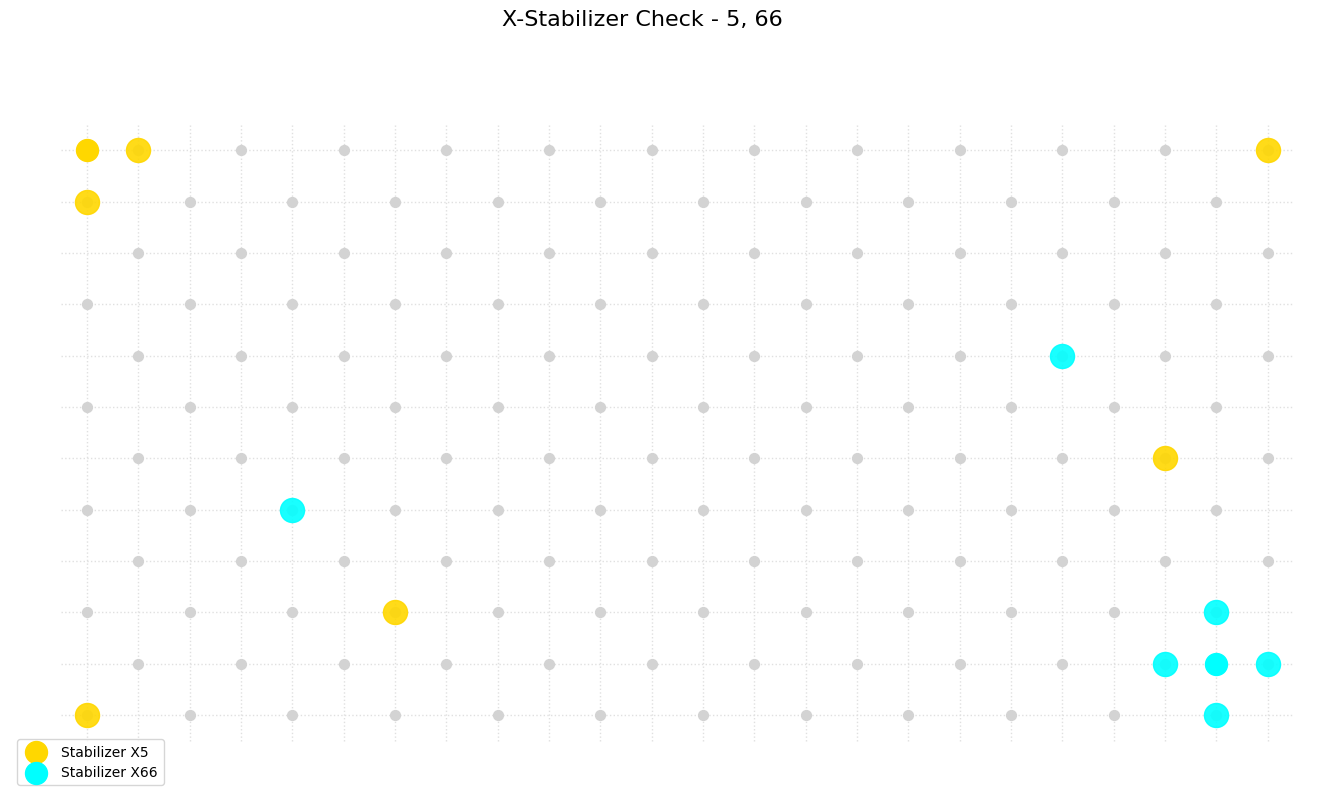

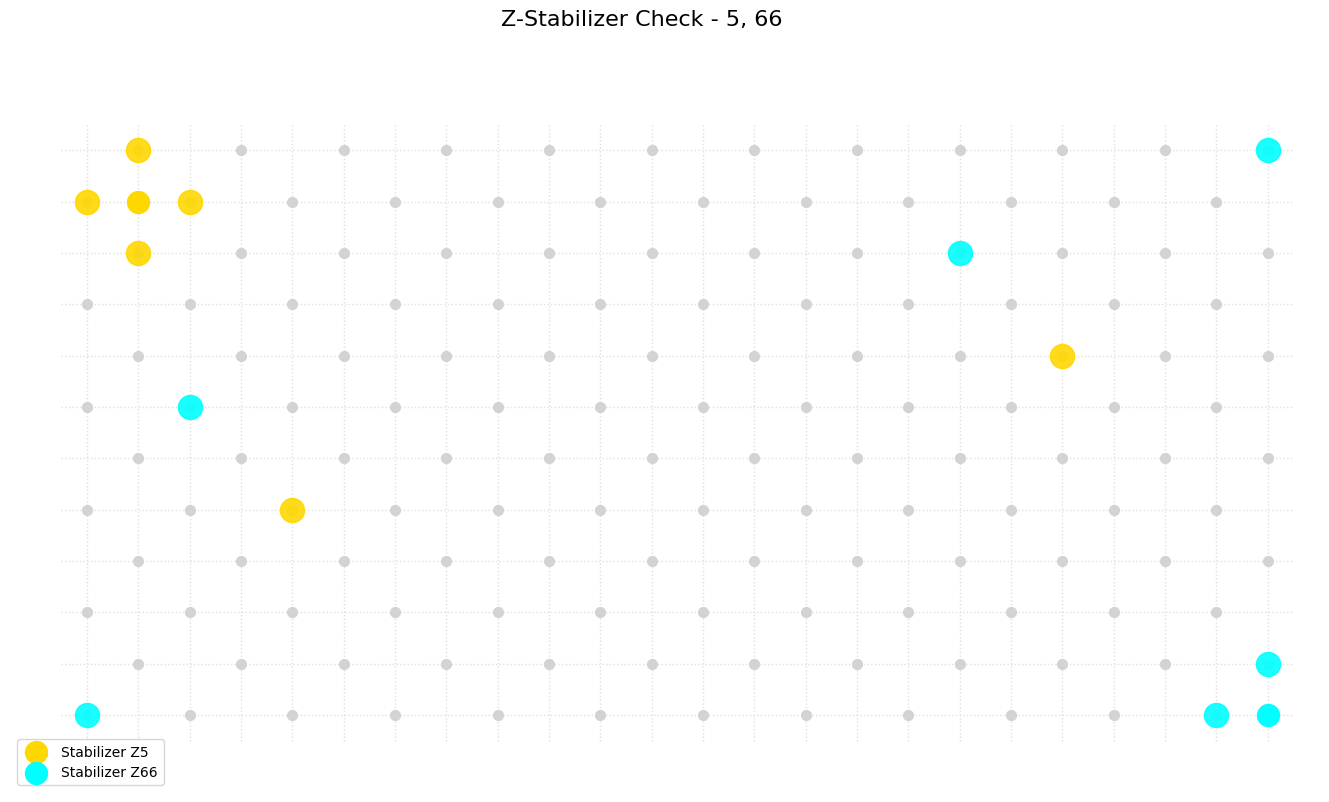

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [25]:


HXgc = np.zeros((72, 144), dtype=int)
HZgc = np.zeros((72, 144), dtype=int)

for col in range(12):
    for row in range(6):
        idx_blue = col * 6 + row       # 0 to 71
        idx_orange = idx_blue + 72     # 72 to 143

        # --- HXgc ---
        HXgc[idx_blue][idx_blue] = 1  # itself
        HXgc[idx_blue][col * 6 + (row + 1) % 6] = 1  # right neighbor (blue)
        HXgc[idx_blue][((col + 3) % 12) * 6 + (row + 2) % 6] = 1  # diagonal far blue
        HXgc[idx_blue][idx_orange] = 1  # own orange
        HXgc[idx_blue][((col - 2) % 12) * 6 + (row + 3) % 6 + 72] = 1  # orange
        HXgc[idx_blue][((col - 1) % 12) * 6 + row + 72] = 1  # orange neighbor

        # --- HZgc ---
        HZgc[idx_blue][idx_blue] = 1  # itself
        HZgc[idx_blue][col * 6 + (row - 1) % 6 + 72] = 1  # orange below
        HZgc[idx_blue][idx_orange] = 1  # own orange
        HZgc[idx_blue][((col + 1) % 12) * 6 + row] = 1  # right neighbor blue
        HZgc[idx_blue][int(6 * ((col + 2) % 12) + (row + 3) % 6)] = 1  # diagonal far blue
        HZgc[idx_blue][int(72 + 6 * ((col - 3) % 12) + (row - 2) % 6)] = 1  # far orange
           # long-range diagonal bottom-right

# Visualize and grade
generate_stabilizer_plots(HXgc, HZgc)
grade_lab4_ex5(HXgc, HZgc)



# Optional: Visual check
generate_stabilizer_plots(HXgc, HZgc)

# Grade submission
grade_lab4_ex5(HXgc, HZgc)

In [26]:
from lab4_util import matrixRank

# Total number of physical qubits
n = 144

# --- Toric Code ---
rx_toric = matrixRank(HXtc)
rz_toric = matrixRank(HZtc)
k_toric = n - rx_toric - rz_toric

# --- Gross Code ---
rx_gross = matrixRank(HXgc)
rz_gross = matrixRank(HZgc)
k_gross = n - rx_gross - rz_gross

# Submit your answer
grade_lab4_ex6(k_toric, k_gross)


Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [27]:
# Check your submission status with the code below
from qc_grader.grader.grade import check_lab_completion_status

check_lab_completion_status("qgss_2025")

Lab 0: 2/2 exercises completed (100%)
    ✅ 2573 participants have completed this lab
Lab 1: 9/9 exercises completed (100%)
    ✅ 2227 participants have completed this lab
Lab 2: 7/7 exercises completed (100%)
    ✅ 1508 participants have completed this lab
Lab 3: 5/5 exercises completed (100%)
    ✅ 1391 participants have completed this lab
Lab 4: 6/6 exercises completed (100%)
    ✅ 1365 participants have completed this lab
Functions Labs: 0/8 exercises completed (0%)
    ✅ 6 participants have completed this lab
